In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display as ld

In [ ]:
def get_speaker_gender(txt_file, directory):
    speaker_data = {}
    female_speakers = []
    male_speakers = []

    # Read the TXT file
    with open(txt_file, 'r') as file:
        lines = file.readlines()

    # Parse the data
    for line in lines:
        if line.startswith(';'):
            continue
        speaker_id, gender, subset, *_ = line.strip().split('|')
        if subset.strip() == 'dev-clean':
            speaker_data[speaker_id.strip()] = 1 if gender.strip() == 'M' else 0

    # Get speaker ids from directory
    for speaker_id in speaker_data.keys():
        speaker_dir = os.path.join(directory, speaker_id)
        if os.path.exists(speaker_dir):
            if speaker_data[speaker_id] == 0:
                female_speakers.append(speaker_id)
            elif speaker_data[speaker_id] == 1:
                male_speakers.append(speaker_id)

    return speaker_data, female_speakers, male_speakers

txt_file_path = "/content/drive/MyDrive/dev-clean/LibriSpeech/SPEAKERS.TXT"
directory_path = "/content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/"
speaker_data, female_speakers, male_speakers = get_speaker_gender(txt_file_path, directory_path)
print(speaker_data, female_speakers, male_speakers)



{'84': 0, '174': 1, '251': 1, '422': 1, '652': 1, '777': 1, '1272': 1, '1462': 0, '1673': 0, '1919': 0, '1988': 0, '1993': 0, '2035': 0, '2078': 1, '2086': 1, '2277': 0, '2412': 0, '2428': 1, '2803': 1, '2902': 1, '3000': 1, '3081': 0, '3170': 1, '3536': 0, '3576': 0, '3752': 1, '3853': 0, '5338': 0, '5536': 1, '5694': 1, '5895': 0, '6241': 1, '6295': 1, '6313': 0, '6319': 0, '6345': 0, '7850': 0, '7976': 1, '8297': 1, '8842': 0} ['84', '1462', '1673', '1919', '1988', '1993', '2035', '2277', '2412', '3081', '3536', '3576', '3853', '5338', '5895', '6313', '6319', '6345', '7850', '8842'] ['174', '251', '422', '652', '777', '1272', '2078', '2086', '2428', '2803', '2902', '3000', '3170', '3752', '5536', '5694', '6241', '6295', '7976', '8297']


In [ ]:
speaker_data['84']

0

In [ ]:
import random

def split_data_equal(male_speakers, female_speakers, percentage):

    # Shuffle male and female speaker IDs separately to ensure randomness
    random.shuffle(male_speakers)
    random.shuffle(female_speakers)

    # Determine the split index based on the given percentage
    split_index = int(min(len(male_speakers), len(female_speakers)) * percentage)

    # Split male and female speaker IDs into training and testing sets
    male_train = male_speakers[:split_index]
    male_test = male_speakers[split_index:]

    female_train = female_speakers[:split_index]
    female_test = female_speakers[split_index:]

    return male_train, female_train, male_test, female_test

percentage = 0.8  # 80% for training, 20% for testing
male_train, female_train, male_test, female_test = split_data_equal(male_speakers, female_speakers, percentage)
print("Male IDs for training:", male_train)
print("Female IDs for training:", female_train)
print("Male IDs for testing:", male_test)
print("Female IDs for testing:", female_test)


Male IDs for training: ['2803', '422', '652', '2078', '251', '5694', '2086', '6241', '3170', '5536', '3752', '2428', '2902', '1272', '174', '7976']
Female IDs for training: ['2035', '3536', '1673', '1988', '5895', '1919', '3853', '1462', '7850', '6313', '6345', '84', '8842', '2277', '3081', '2412']
Male IDs for testing: ['8297', '3000', '6295', '777']
Female IDs for testing: ['1993', '6319', '3576', '5338']


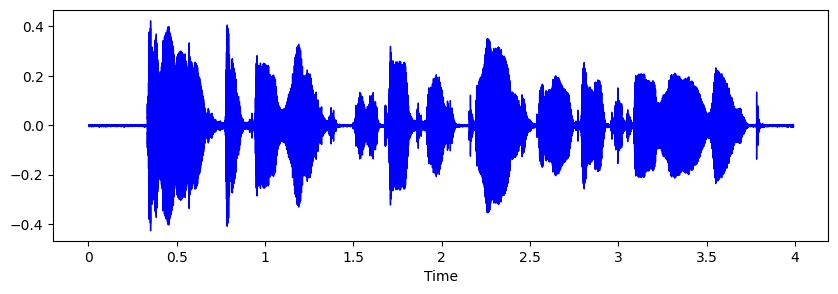

In [ ]:
# Show the sample .wav file
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    ld.waveshow(data, sr=sr, color="blue")
    plt.show()

path = "/content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/84/121123/84-121123-0001.flac"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)

In [ ]:

import librosa
import numpy as np

def get_mfcc_features(audio_file, sr=22050, n_mfcc=13):
    """
    Extracts MFCC features from an audio file.

    Parameters:
        audio_file (str): Path to the audio file.
        sr (int): Sampling rate. Default is 22050.
        n_mfcc (int): Number of MFCC coefficients to extract. Default is 13.

    Returns:
        mfcc_features (np.ndarray): MFCC features matrix.
    """
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=sr)

    # Extract MFCC features
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft = 2048, hop_length = 1024).T

    return mfcc_features

# dataset = np.ndarray(shape=(0, 13))
# gender_vector = np.ndarray(shape=(0,1))

# mfcc_features = get_mfcc_features(path)
# print("Shape of MFCC features:", mfcc_features.shape)
# print(np.mean(mfcc_features, axis=0))
# mean_mfcc = np.expand_dims(np.mean(mfcc_features,axis=0),axis=1)
# dataset = np.append(dataset,mean_mfcc)
# gender_vector = np.append(gender_vector,np.expand_dims(1*np.ones(mean_mfcc.shape[0]),axis=1),axis=0)

# print(mean_mfcc, dataset, gender_vector)


In [49]:
def extract_mfcc_features(directory, speaker_ids, sr=22050, n_mfcc=40, hop_length=512, n_fft=2048):
    """
    Extract features from all speakers based on the given speaker list
    """
    all_mfcc_features = []
    gender = []
    for speaker_id in speaker_ids:
        speaker_dir = os.path.join(directory, str(speaker_id))
        if not os.path.exists(speaker_dir):
            continue

        for root, dirs, files in os.walk(speaker_dir):
            for file in files:
                if file.endswith('.flac'):
                    audio_file = os.path.join(root, file)
                    y, sr = librosa.load(audio_file, sr=sr)
                    mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft).T
                    # print(mfcc_features.shape)
                    mean_mfcc = np.mean(mfcc_features, axis = 0)
                    all_mfcc_features.append(mean_mfcc)
                    gender.append([speaker_data[str(speaker_id)]])
    return np.array(all_mfcc_features), np.array(gender)

directory = "/content/drive/MyDrive/dev-clean/LibriSpeech/dev-clean/"
male_mfcc_features_train, male_gender_train = extract_mfcc_features(directory, male_train)
female_mfcc_features_train, female_gender_train = extract_mfcc_features(directory, female_train)
male_mfcc_features_test, male_gender_test = extract_mfcc_features(directory, male_test)
female_mfcc_features_test, female_gender_test = extract_mfcc_features(directory, female_test)


In [50]:
train_dataset = np.concatenate((male_mfcc_features_train, female_mfcc_features_train), axis = 0)
train_dataset_gender = np.concatenate((male_gender_train, female_gender_train), axis = 0)
print("Shape of MFCC features array:", train_dataset.shape, train_dataset_gender.shape)

test_dataset = np.concatenate((male_mfcc_features_test, female_mfcc_features_test), axis = 0)
test_dataset_gender = np.concatenate((male_gender_test, female_gender_test), axis = 0)

Shape of MFCC features array: (2212, 40) (2212, 1)


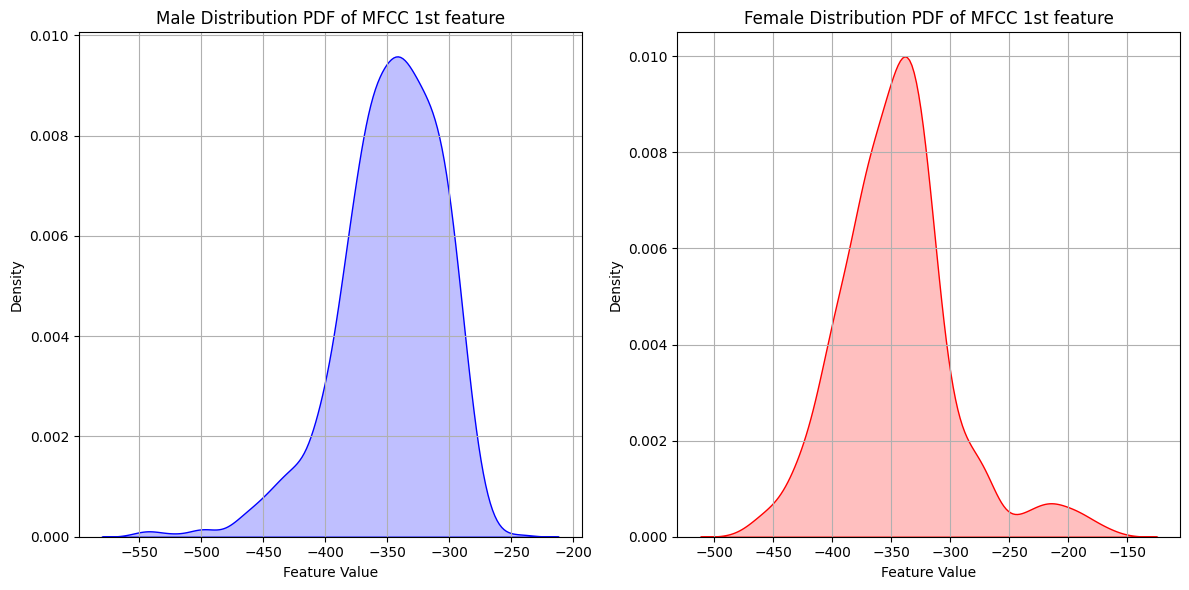

In [66]:
male_mfcc_energy = male_mfcc_features_train[:, 0]
female_mfcc_energy = female_mfcc_features_train[:, 0]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original X_train data with KDE
sns.kdeplot(male_mfcc_energy, color='blue', fill=True, ax=axs[0])
axs[0].set_title('Male Distribution PDF of MFCC 1st feature')
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Density')
axs[0].grid(True)

# Plot the distribution of the 1st feature with KDE
sns.kdeplot(female_mfcc_energy, color='red', fill=True, ax=axs[1])
axs[1].set_title('Female Distribution PDF of MFCC 1st feature')
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Density')
axs[1].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

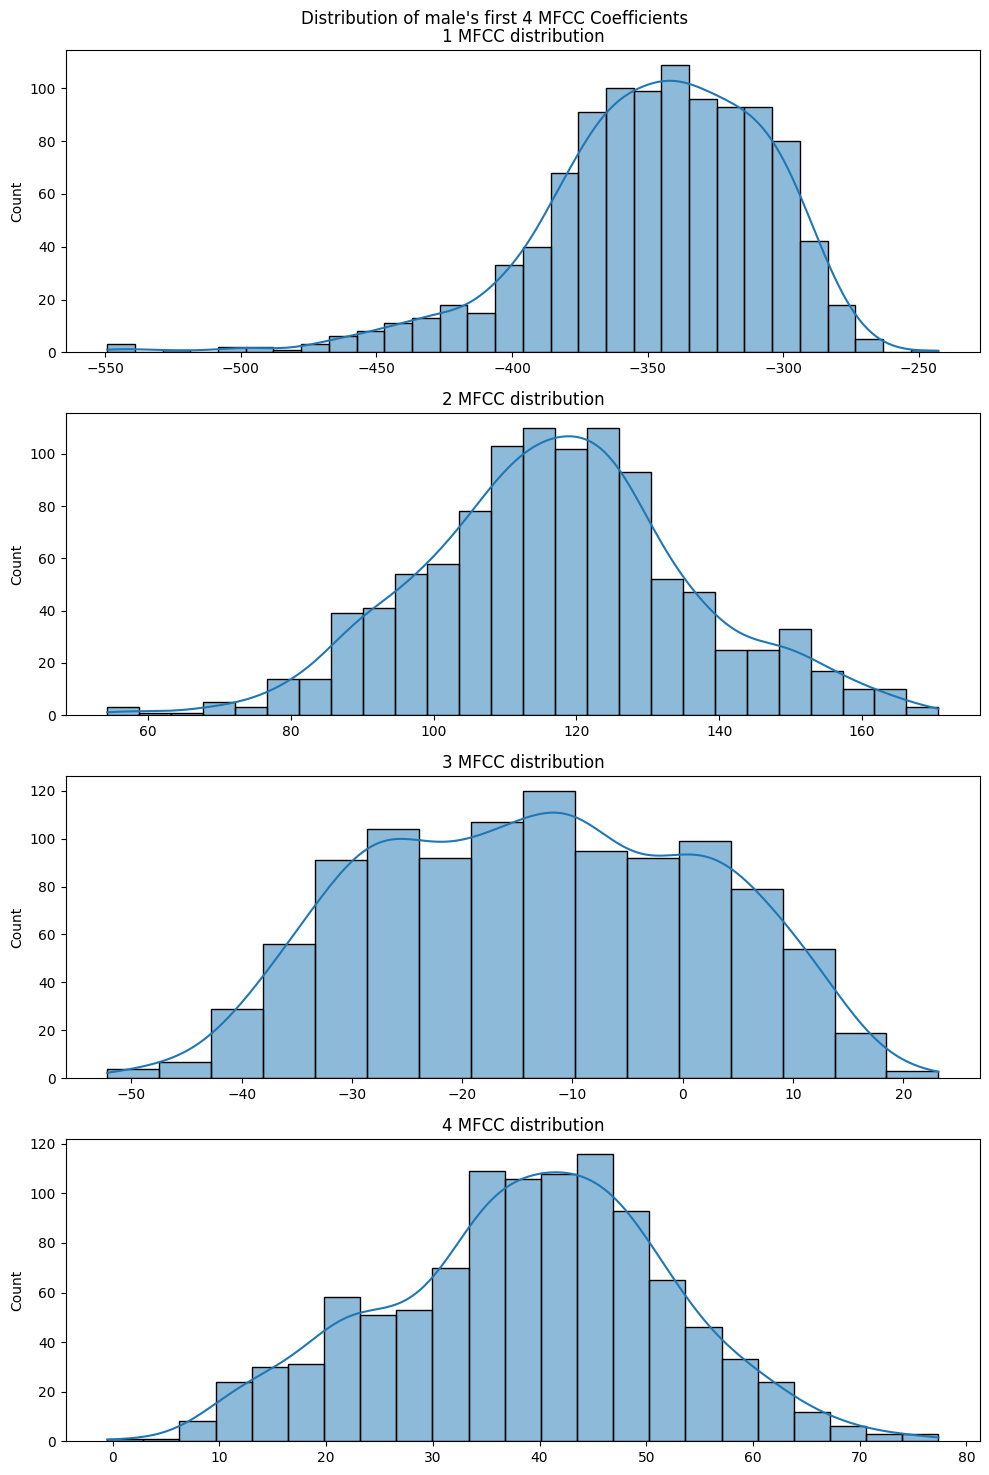

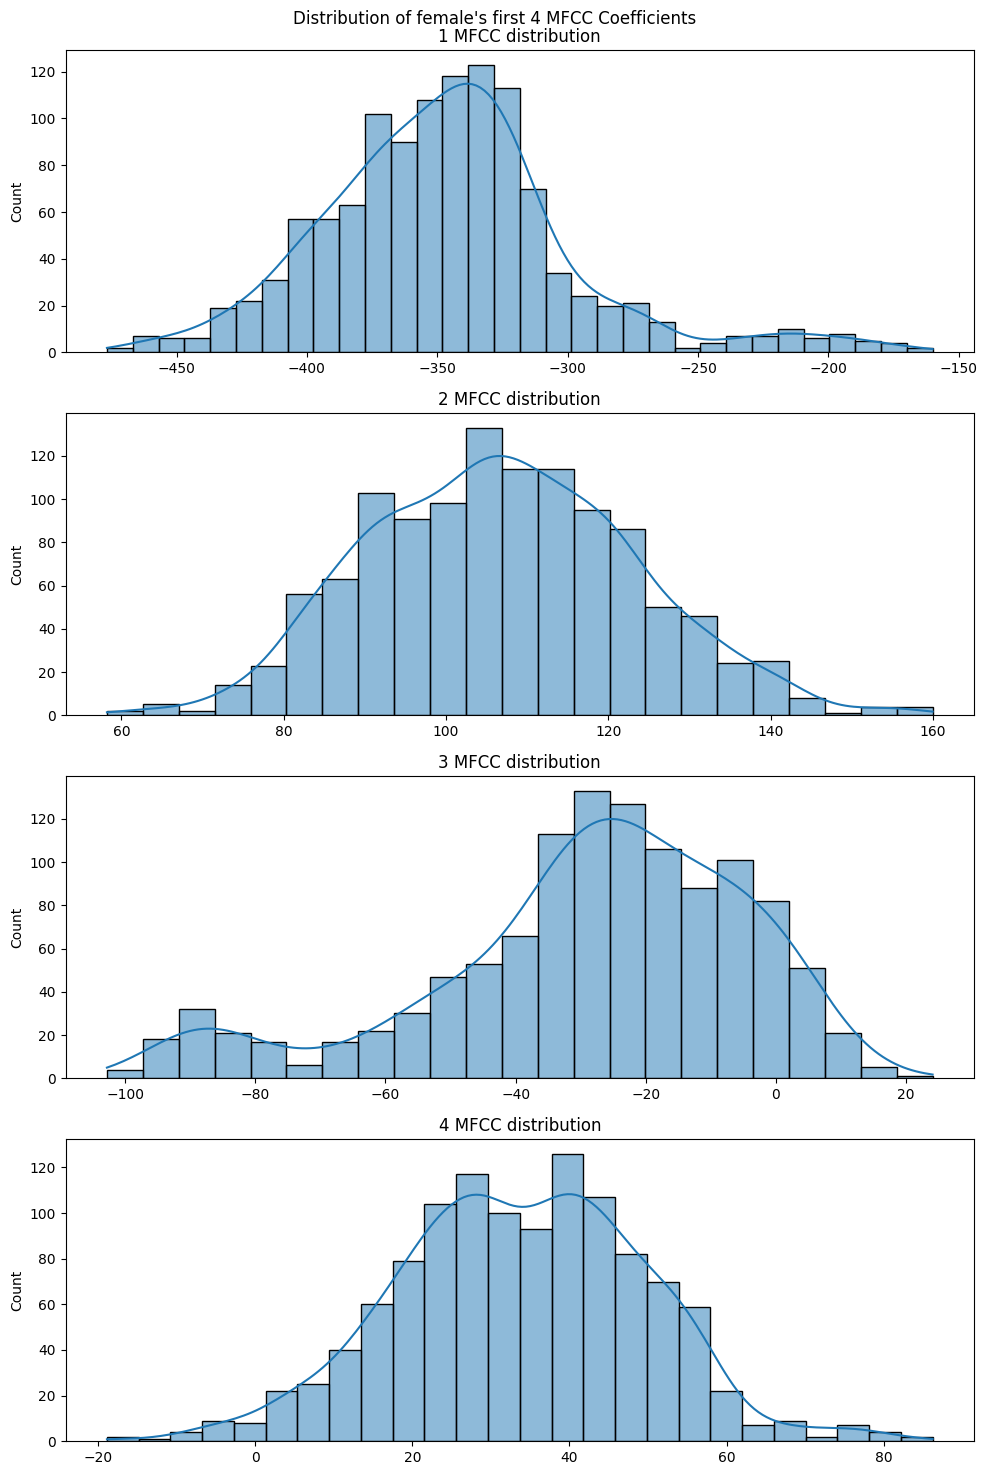

In [79]:
fig, axes = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Distribution of male's first 4 MFCC Coefficients")
for i in range(4):
    sns.histplot(male_mfcc_features_train[:, i], fill=True, ax=axes[i], kde=True)
    axes[i].set_title(f"{i+1} MFCC distribution")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle("Distribution of female's first 4 MFCC Coefficients")
for i in range(4):
    sns.histplot(female_mfcc_features_train[:, i], fill=True, ax=axes[i], kde=True)
    axes[i].set_title(f"{i+1} MFCC distribution")
plt.tight_layout()
plt.show()

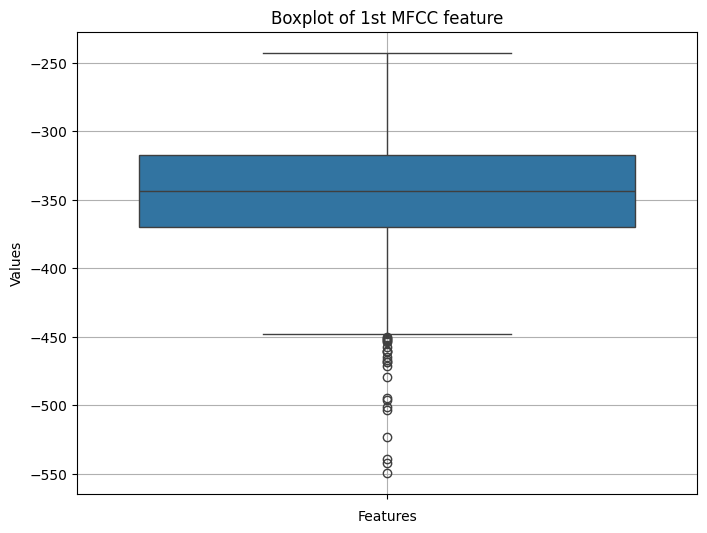

In [95]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=male_mfcc_features_train[:, 0])
plt.title('Boxplot of 1st MFCC feature')
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid(True)
plt.show()

filtered = male_mfcc_features_train[:, 0][(male_mfcc_features_train[:, 0] >= -250) & (male_mfcc_features_train[:, 0] <= -450)]


(1161, 40) (1161, 40)


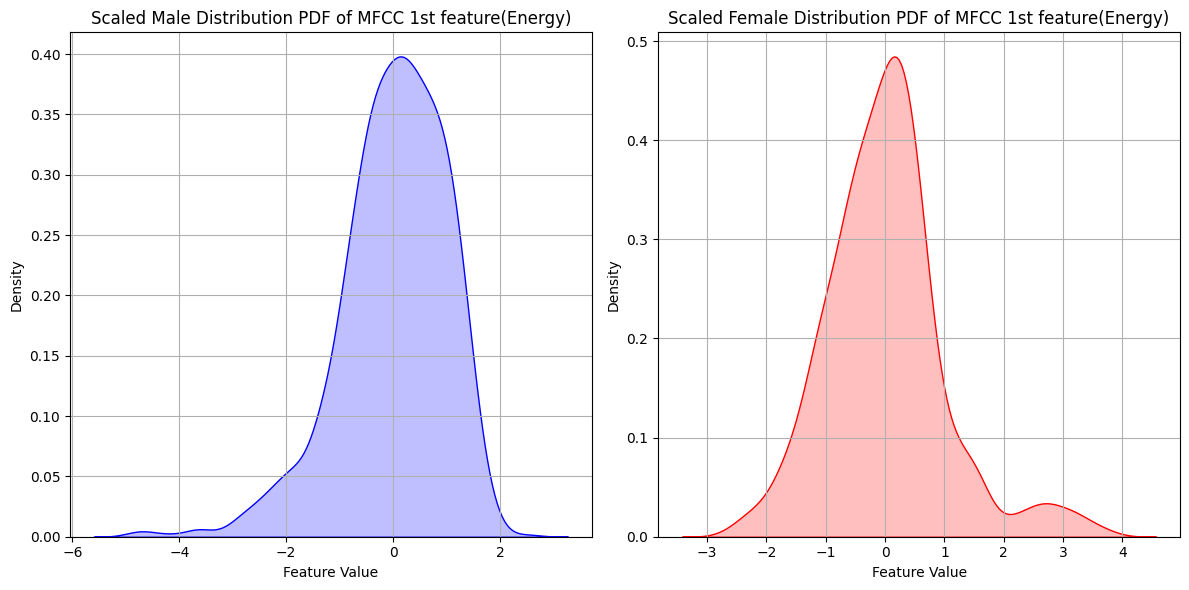

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#for male
scaler.fit(male_mfcc_features_train)
male_mfcc_features_train_scaled = scaler.transform(male_mfcc_features_train)
#for female
scaler = StandardScaler()
scaler.fit(female_mfcc_features_train)
female_mfcc_features_train_scaled = scaler.transform(female_mfcc_features_train)
print(female_mfcc_features_train.shape, female_mfcc_features_train_scaled.shape)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


sns.kdeplot(male_mfcc_features_train_scaled[:, 0], color='blue', fill=True, ax=axs[0])
axs[0].set_title('Scaled Male Distribution PDF of MFCC 1st feature(Energy)')
axs[0].set_xlabel('Feature Value')
axs[0].set_ylabel('Density')
axs[0].grid(True)


sns.kdeplot(female_mfcc_features_train_scaled[:, 0], color='red', fill=True, ax=axs[1])
axs[1].set_title('Scaled Female Distribution PDF of MFCC 1st feature(Energy)')
axs[1].set_xlabel('Feature Value')
axs[1].set_ylabel('Density')
axs[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy
import torch
print(torch.__version__)

2.1.0+cu121


In [ ]:
!pip install --user tensorflow
!pip install --user keras

In [51]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

(2212, 40) (2212, 1)
(491, 40) (491, 1)
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1161
           1       0.92      0.87      0.89      1051

    accuracy                           0.90      2212
   macro avg       0.90      0.90      0.90      2212
weighted avg       0.90      0.90      0.90      2212

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       213
           1       0.90      1.00      0.95       278

    accuracy                           0.93       491
   macro avg       0.95      0.92      0.93       491
weighted avg       0.94      0.93      0.93       491



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


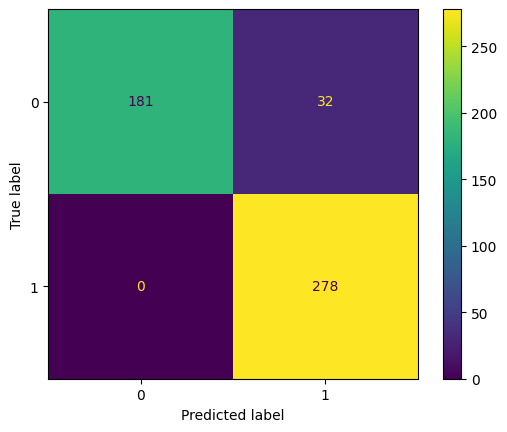

In [88]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

print(train_dataset.shape, train_dataset_gender.shape)
print(test_dataset.shape, test_dataset_gender.shape)
clf = GaussianNB()
clf.fit(train_dataset, train_dataset_gender)
y_train_pred = clf.predict(train_dataset)
print(classification_report(train_dataset_gender, y_train_pred))
y_test_pred = clf.predict(test_dataset)
print(classification_report(test_dataset_gender, y_test_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_dataset_gender, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1161
           1       0.98      0.87      0.92      1051

    accuracy                           0.93      2212
   macro avg       0.94      0.93      0.93      2212
weighted avg       0.93      0.93      0.93      2212

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       213
           1       0.83      1.00      0.91       278

    accuracy                           0.89       491
   macro avg       0.91      0.87      0.88       491
weighted avg       0.90      0.89      0.88       491



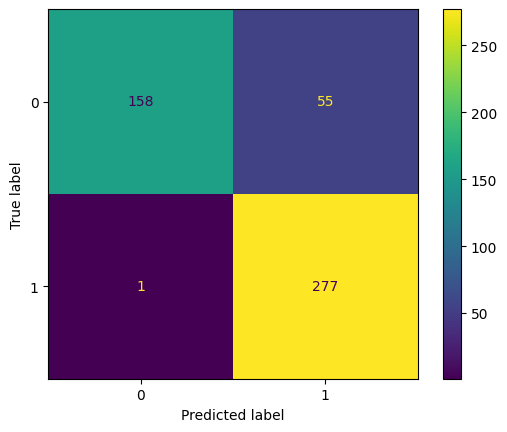

In [87]:
from sklearn.svm import SVC

# Create an SVM classifier
svm_classifier = SVC(kernel='poly', C=1.0)

# Train the SVM model
svm_classifier.fit(train_dataset, train_dataset_gender)

# Predict using the SVM model
y_train_pred = svm_classifier.predict(train_dataset)
y_test_pred = svm_classifier.predict(test_dataset)

print(classification_report(train_dataset_gender, y_train_pred))
print(classification_report(test_dataset_gender, y_test_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_dataset_gender, y_test_pred, labels=svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1161
           1       0.98      0.99      0.98      1051

    accuracy                           0.98      2212
   macro avg       0.98      0.98      0.98      2212
weighted avg       0.98      0.98      0.98      2212

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       213
           1       0.86      0.99      0.92       278

    accuracy                           0.91       491
   macro avg       0.92      0.89      0.90       491
weighted avg       0.92      0.91      0.90       491



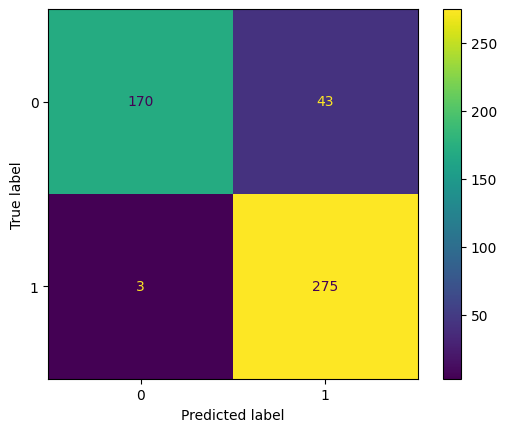

In [86]:
from sklearn.neural_network import MLPClassifier

# Create an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(5,2),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam')
# Train the model
mlp_clf.fit(train_dataset, train_dataset_gender)

# Predict using the MLP model
y_train_pred = mlp_clf.predict(train_dataset)
y_test_pred = mlp_clf.predict(test_dataset)
print(classification_report(train_dataset_gender, y_train_pred))
print(classification_report(test_dataset_gender, y_test_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_dataset_gender, y_test_pred, labels=mlp_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_clf.classes_)
disp.plot()
plt.show()

In [52]:
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

X_train = train_dataset
X_test = test_dataset
Y_train = encoder.fit_transform(train_dataset_gender)
Y_test = encoder.fit_transform(test_dataset_gender)

input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=30, batch_size=10)

Epoch 1/30
177/177 [==============================] - 3s 9ms/step - loss: 1.1193 - accuracy: 0.5726 - val_loss: 0.5755 - val_accuracy: 0.8420
Epoch 2/30
177/177 [==============================] - 1s 6ms/step - loss: 0.5101 - accuracy: 0.7394 - val_loss: 0.3328 - val_accuracy: 0.8623
Epoch 3/30
177/177 [==============================] - 1s 6ms/step - loss: 0.4214 - accuracy: 0.7965 - val_loss: 0.2703 - val_accuracy: 0.8984
Epoch 4/30
177/177 [==============================] - 1s 8ms/step - loss: 0.3323 - accuracy: 0.8468 - val_loss: 0.2117 - val_accuracy: 0.9052
Epoch 5/30
177/177 [==============================] - 1s 6ms/step - loss: 0.2775 - accuracy: 0.8672 - val_loss: 0.1489 - val_accuracy: 0.9345
Epoch 6/30
177/177 [==============================] - 1s 6ms/step - loss: 0.2123 - accuracy: 0.9033 - val_loss: 0.1258 - val_accuracy: 0.9458
Epoch 7/30
177/177 [==============================] - 1s 7ms/step - loss: 0.1976 - accuracy: 0.9152 - val_loss: 0.1120 - val_accuracy: 0.9413
Epoch 

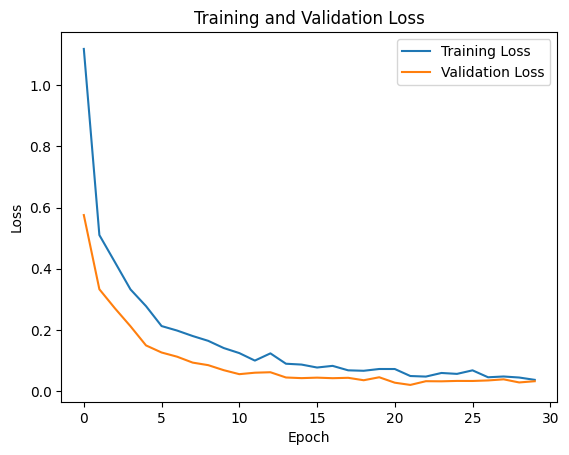

In [53]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
scores = model.evaluate(X_test, Y_test)
print(scores)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

16/16 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.9308
[0.42771410942077637, 0.9307535886764526]

accuracy: 93.08%


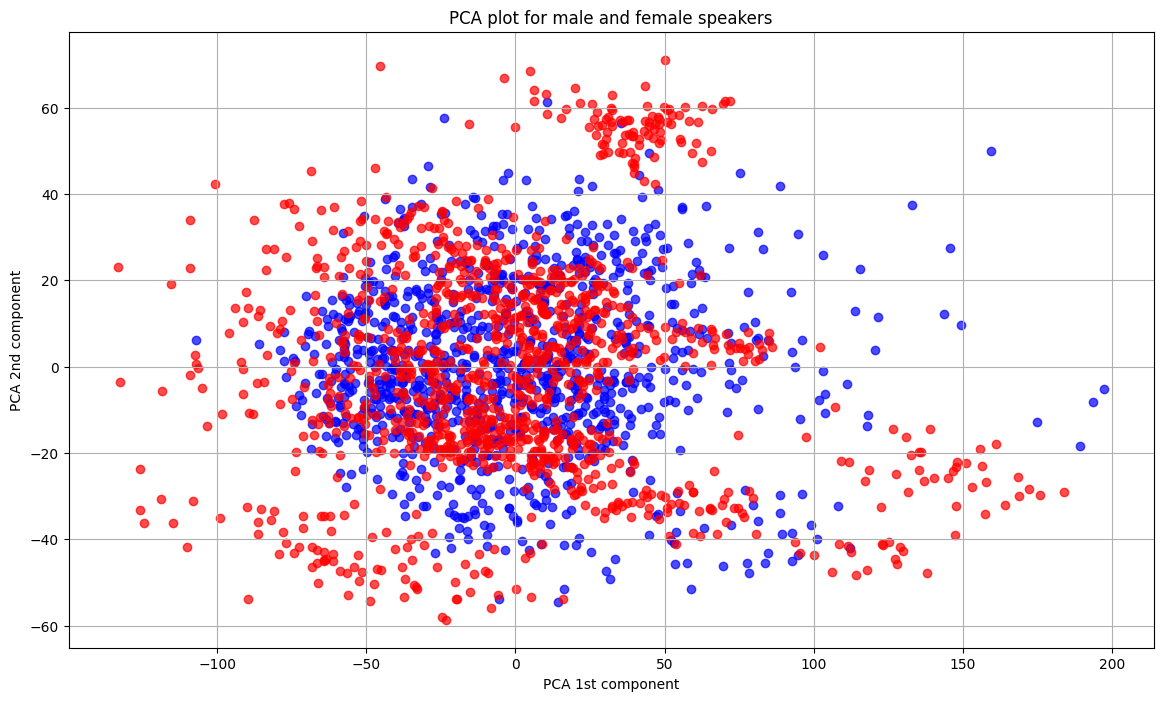

In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_male_dataset = pca.fit_transform(male_mfcc_features_train)
pca = PCA(n_components=2)
pca_female_dataset = pca.fit_transform(female_mfcc_features_train)

plt.figure(figsize=(14, 8))
plt.scatter(pca_male_dataset[:, 0], pca_male_dataset[:, 1], c='blue', alpha=0.7)
plt.scatter(pca_female_dataset[:, 0], pca_female_dataset[:, 1], c='red', alpha=0.7)
plt.title('PCA plot for male and female speakers')
plt.xlabel('PCA 1st component')
plt.ylabel('PCA 2nd component')
plt.grid(True)
plt.show()

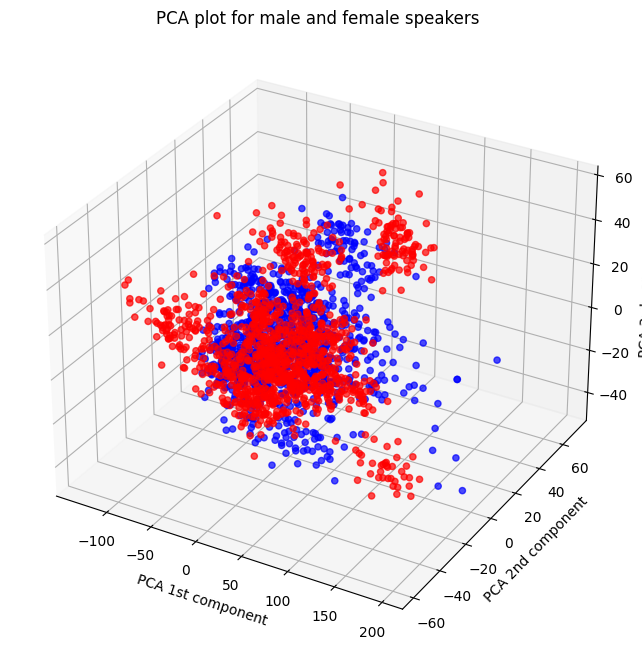

In [104]:
pca = PCA(n_components=3)
pca_male_dataset = pca.fit_transform(male_mfcc_features_train)
pca = PCA(n_components=3)
pca_female_dataset = pca.fit_transform(female_mfcc_features_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_male_dataset[:, 0], pca_male_dataset[:, 1], pca_male_dataset[:, 2], c='blue', alpha=0.7)
ax.scatter(pca_female_dataset[:, 0], pca_female_dataset[:, 1], pca_female_dataset[:, 2], c='red', alpha=0.7)
ax.set_title('PCA plot for male and female speakers')
ax.set_xlabel('PCA 1st component')
ax.set_ylabel('PCA 2nd component')
ax.set_zlabel('PCA 3rd component')
ax.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


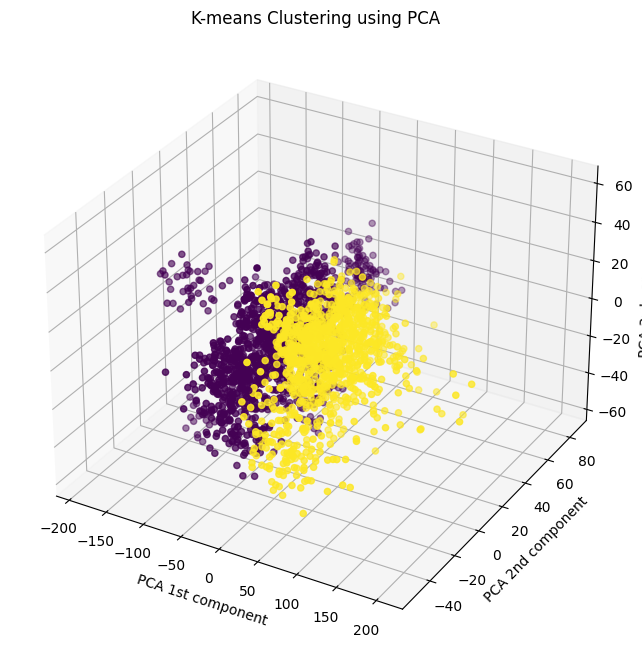

In [106]:
from sklearn.cluster import KMeans

n_clusters = 2
#Perform PCA to reduce size to 3 features
pca = PCA(n_components=3)
pca_dataset = pca.fit_transform(train_dataset)
#K-means clustering
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(train_dataset)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_dataset[:, 0], pca_dataset[:, 1], pca_dataset[:, 2], c=labels)
ax.set_title('K-means Clustering using PCA ')
ax.set_xlabel('PCA 1st component')
ax.set_ylabel('PCA 2nd component')
ax.set_zlabel('PCA 3rd component')
plt.show()